In [6]:
import pandas as pd
import numpy as np
import math

In [7]:
from sklearn.model_selection import KFold, GridSearchCV

## misc function

In [8]:
def train_test_split(X, y, test_p=0.25, random_state=42):
    ids = np.unique(X.index.values)
    test_size = math.floor(test_p * len(ids))
    test_index = np.random.choice(ids, size=test_size)
    X_train = X[~X.index.isin(test_index)]
    X_test = X[X.index.isin(test_index)]
    y_train = y[~y.index.isin(test_index)]
    y_test = y[y.index.isin(test_index)]
    return X_train, X_test, y_train, y_test

In [41]:
data = pd.read_csv('../results/04_02_250103127/data/All_GEMCITABINE.tsv', sep='\t', index_col=0)

In [70]:
!ls ../results/04_02_250103127/data/All_GEMCITABINE.tsv

../results/04_02_250103127/data/All_GEMCITABINE.tsv


In [42]:
data = data.drop_duplicates()

In [43]:
X_columns = data.columns.values[pd.Series(data.columns.values).str.contains('ENSG')]

In [44]:
X = data.loc[:, X_columns]

In [45]:
y = data.loc[:, 'y_trans']
y_discrete = y > 0

In [46]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

## RBF

In [47]:
from sklearn.svm import SVC, SVR

In [48]:
from scipy.stats import spearmanr

In [49]:
print('SVC with linear kernel')
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y_discrete[train_index], y_discrete[test_index]
    svc_rbf = SVC(C=10, kernel='linear', gamma='auto')
    svc_rbf.fit(X_train, y_train)
    print(svc_rbf.score(X_test, y_test))

SVC with linear kernel
0.8214285714285714
0.8571428571428571
0.8214285714285714
0.8888888888888888
0.7037037037037037


In [50]:
print('SVR with RBF')
corrs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    svr_rbf = SVR(C=10, kernel='linear', gamma='auto')
    svr_rbf.fit(X_train, y_train)
    y_pred = svr_rbf.predict(X_test)
    corrs.append(spearmanr(y_pred, y_test))
    print(svr_rbf.score(X_test, y_test))

SVR with RBF
0.19658870841629716
0.3457520685896165
0.09099327630280375
0.23607785587471342
0.24361510246461093


In [51]:
[(x.correlation, x.pvalue) for x in corrs]

[(0.6867041006456535, 5.4503190645682736e-05),
 (0.7320550417900729, 9.528963841332777e-06),
 (0.7098452757222468, 2.331030624764042e-05),
 (0.5607232188520123, 0.002347234555157577),
 (0.5348801771980332, 0.004045826605704046)]

In [52]:
corrs

[SpearmanrResult(correlation=0.6867041006456535, pvalue=5.4503190645682736e-05),
 SpearmanrResult(correlation=0.7320550417900729, pvalue=9.528963841332777e-06),
 SpearmanrResult(correlation=0.7098452757222468, pvalue=2.331030624764042e-05),
 SpearmanrResult(correlation=0.5607232188520123, pvalue=0.002347234555157577),
 SpearmanrResult(correlation=0.5348801771980332, pvalue=0.004045826605704046)]

In [53]:
weights = pd.DataFrame(data={'weights': svc_rbf.coef_[0],
                   'names': data.columns[:-3]})

In [54]:
weights['weights'] = np.abs(weights['weights'])

In [55]:
weights.sort_values('weights')

,weights,names
2004,6.748709e-18,ENSG00000222617
2941,8.339212e-18,ENSG00000240202
2043,1.354566e-17,ENSG00000223761
2981,1.406609e-17,ENSG00000241317
1219,4.485266e-17,ENSG00000171489
...,...,...
1291,7.928969e-03,ENSG00000174667
2987,8.239967e-03,ENSG00000241592
1678,8.343506e-03,ENSG00000200274
2047,8.772678e-03,ENSG00000223809


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
svc_rbf = SVR(C=10, kernel='linear', gamma='auto')
svc_rbf.fit(X_train, y_train)
svc_rbf.score(X_test, y_test)

0.2847074455454036

In [23]:
params = {"C":[0.1, 1, 10, 50], "gamma": [0.1, 0.01, 0.001, 1, 10]}
grid_search = GridSearchCV(svc_rbf, params,cv=5)
grid_search.fit(X_train,y_train)

/projects/eerhan_prj/anaconda/envs/data/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=10, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto', kernel='linear',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 50],
                         'gamma': [0.1, 0.01, 0.001, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [24]:
grid_search.score(X_test, y_test)

0.284707445544891

### PCA/ t-SNE

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [26]:
pca = PCA(n_components=10)

In [27]:
pca_expression = pca.fit_transform(X)

In [28]:
pca_expression_df = pd.DataFrame(pca_expression, columns=['PC{}'.format(i) for i in range(1, 11)], index=X.index)

In [29]:
pca_expression_df['y_trans'] = data['y_trans']
pca_expression_df['y'] = data['y']
pca_expression_df['discrete'] = [1 if x else 0 for x in y_discrete]

In [30]:
tsne = TSNE(n_components=3)

In [31]:
tsne_expression = tsne.fit_transform(pca_expression)

In [32]:
tsne_expression_df = pd.DataFrame(tsne_expression, columns=['tsne{}'.format(i) for i in range(1, 4)], index=X.index)

In [33]:
tsne_expression_df['y_trans'] = data['y_trans']
tsne_expression_df['y'] = data['y']
tsne_expression_df['discrete'] = [1 if x else 0 for x in y_discrete]

## Try to explain with cancer type

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns

In [35]:
drugs_df = pd.read_csv('../data/processed/drugs_filtered.tsv', sep='\t', index_col=0)

In [36]:
cancer_map = drugs_df[['pog_id', 'cancer_cohort']]

In [37]:
data = cancer_map.join(data, on='pog_id', how='right').drop_duplicates().sort_values('pog_id')

In [38]:
data = data.set_index('pog_id')

In [39]:
data

,cancer_cohort,ENSG00000000005,ENSG00000000419,ENSG00000001626,ENSG00000003137,ENSG00000004142,ENSG00000004660,ENSG00000004809,ENSG00000004864,ENSG00000005001,...,ENSG00000283586,ENSG00000283602,ENSG00000283613,ENSG00000283623,ENSG00000283631,ENSG00000283657,ENSG00000283680,y,y_trans,y_pred
pog_id,,,,,,,,,,,,,,,,,,,,,
POG002,BRCA,-0.129914,-1.030471,-0.304116,-0.319136,-0.862497,-0.258929,-0.250381,-0.616351,-0.480233,...,-0.144894,-0.566874,-0.081262,-1.203965,-0.090896,-0.120957,-0.169479,57,-0.172145,NaN
POG010,BRCA,-0.104556,0.406227,-0.310707,-0.310280,-0.092657,-0.096408,0.078349,-0.755019,-0.447640,...,-0.144894,-0.094724,-0.081262,-1.368603,-0.090896,-0.120957,-0.169479,115,0.528385,NaN
POG014,CHOL,-0.129914,-0.270898,0.481930,-0.334635,-0.390911,-0.633631,-0.250381,0.577531,0.093868,...,-0.144894,-0.368876,-0.081262,-0.922607,-0.090896,-0.120957,-0.169479,120,0.573717,NaN
POG018,PANC,-0.129914,0.761455,-0.181102,-0.375596,-0.721985,-0.651689,1.064538,1.261232,-0.832955,...,-0.144894,-0.566874,-0.081262,-1.481637,-0.090896,-0.120957,-0.169479,71,0.037811,NaN
POG023,BRCA,-0.118820,-0.080566,-0.275193,0.274248,-0.488141,-0.173154,2.572827,-0.365710,-0.482815,...,-0.144894,-0.338414,-0.081262,-0.727254,-0.090896,-0.120957,-0.169479,155,0.853617,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POG920,PANC,-0.129914,-0.173101,-0.266041,-0.171897,0.326417,0.111258,-0.028005,0.452210,2.629724,...,-0.144894,-0.521182,-0.081262,-0.601933,-0.090896,-0.120957,-0.169479,161,0.896240,NaN
POG926,SARC,-0.125952,-0.862505,-0.279953,1.379094,0.315545,0.086429,4.467858,-0.409461,-0.824888,...,-0.144894,-0.551643,-0.081262,0.646362,-0.045396,-0.120957,-0.169479,13,-1.391995,NaN
POG935,PANC,-0.129914,-0.960302,-0.292401,-0.190717,-0.439321,-0.148324,3.307635,-0.542197,-0.534449,...,-0.144894,1.078036,-0.081262,-0.670737,-0.090896,-0.120957,-0.169479,29,-0.769395,True


In [40]:
data['y_true'] = data['y_trans'] > 0

In [24]:
# data.to_csv('../ismb_poster/gemcitabine.tsv', sep='\t')

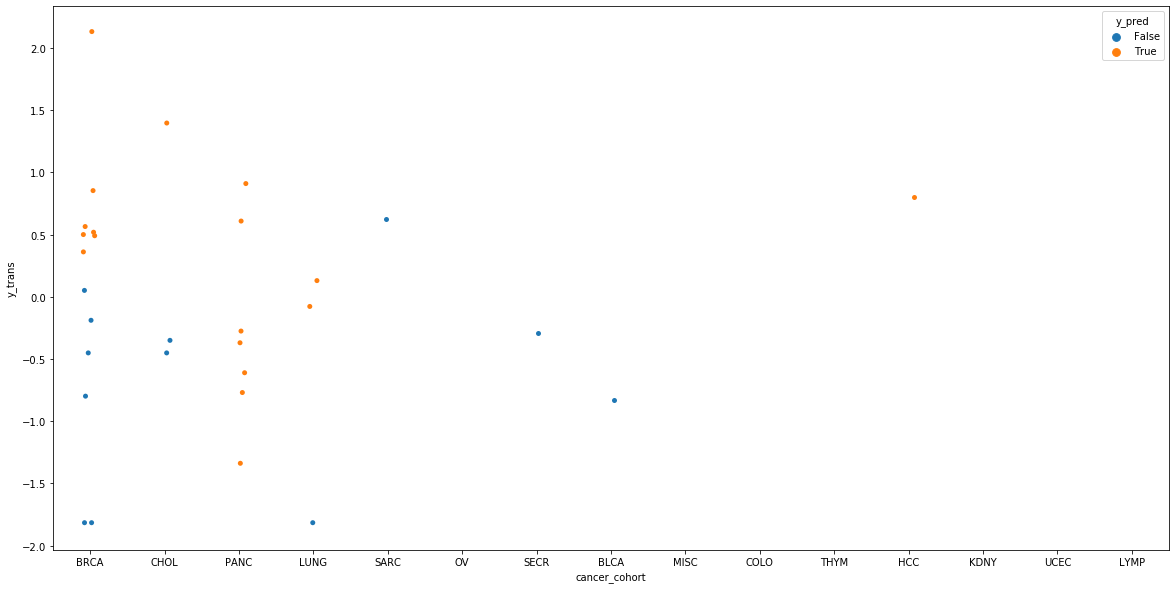

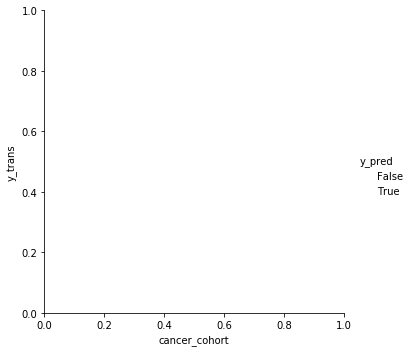

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
sns.catplot(data=data, ax=ax, x='cancer_cohort', y='y_trans', hue='y_pred')

## Try BRCA GEM

In [21]:
brca_data = data[data['cancer_cohort'] == 'BRCA']

In [244]:
data = brca_data

In [245]:
X_columns = data.columns.values[pd.Series(data.columns.values).str.contains('ENSG')]

In [246]:
X = data.loc[:, X_columns]

In [247]:
y = data.loc[:, 'y_trans']
y_discrete = y > 0

In [248]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

## RBF

In [267]:
from sklearn.svm import SVC, SVR

In [268]:
from scipy.stats import spearmanr

In [269]:
print('SVC with linear kernel')
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y_discrete[train_index], y_discrete[test_index]
    svc_rbf = SVC(C=1, kernel='linear', gamma='auto')
    svc_rbf.fit(X_train, y_train)
    print(svc_rbf.score(X_test, y_test))

SVC with linear kernel
0.7272727272727273
0.6363636363636364
0.5454545454545454
0.9090909090909091
0.6363636363636364


In [270]:
print('SVR with linear kernel')
corrs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    svr_rbf = SVR(C=10, kernel='linear', gamma='auto')
    svr_rbf.fit(X_train, y_train)
    y_pred = svr_rbf.predict(X_test)
    corrs.append(spearmanr(y_pred, y_test))
    print(svr_rbf.score(X_test, y_test))

SVR with linear kernel
-2.0797387205826086
-0.47080247193205943
-0.24166275156452754
-1.1844386731756478
0.11960368996595483


In [271]:
[(x.correlation, x.pvalue) for x in corrs]

[(0.2876742319356506, 0.39100355454086044),
 (0.3698630136986301, 0.262893732707693),
 (0.5181818181818182, 0.10249153979096383),
 (-0.04187178946793119, 0.9027128456856279),
 (0.6727272727272727, 0.023313039833185972)]

In [272]:
corrs

[SpearmanrResult(correlation=0.2876742319356506, pvalue=0.39100355454086044),
 SpearmanrResult(correlation=0.3698630136986301, pvalue=0.262893732707693),
 SpearmanrResult(correlation=0.5181818181818182, pvalue=0.10249153979096383),
 SpearmanrResult(correlation=-0.04187178946793119, pvalue=0.9027128456856279),
 SpearmanrResult(correlation=0.6727272727272727, pvalue=0.023313039833185972)]

### Visualize

In [104]:
sns.set(rc={'figure.figsize':(10,10)})

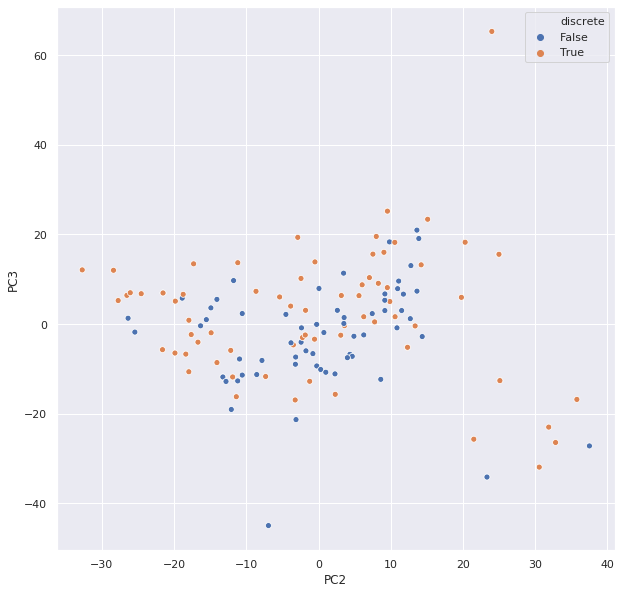

In [110]:
sns.scatterplot(data=pca_expression_df, x='PC2', y='PC3', hue='discrete')
plt.show()

In [138]:
visualize = pca_expression_df.loc[:, ['PC{}'.format(i) for i in range(1, 5)]+['discrete']]

In [139]:
visualize

,PC1,PC2,PC3,PC4,discrete
pog_id,,,,,
POG002,-28.607033,-6.941734,-44.994723,46.556215,0
POG010,-7.023362,6.255390,1.636111,17.691388,1
POG014,5.220870,-12.163231,-5.878475,11.580250,1
POG018,8.540169,-2.881287,19.362237,-7.463735,1
POG023,16.735203,19.773474,5.967540,29.556615,1
...,...,...,...,...,...
POG920,16.377580,-18.749892,6.639477,1.596461,1
POG926,32.196789,23.318903,-34.160990,-11.395275,0
POG935,1.234588,-12.818680,-12.812470,4.938487,0


,PC1,PC2,PC3,PC4,discrete
PC1,1.000000e+00,4.065921e-16,2.742775e-16,6.936079e-18,0.282495
PC2,4.065921e-16,1.000000e+00,2.831602e-16,-1.843924e-16,-0.011634
PC3,2.742775e-16,2.831602e-16,1.000000e+00,1.319041e-16,0.197968
PC4,6.936079e-18,-1.843924e-16,1.319041e-16,1.000000e+00,0.218770
discrete,2.824951e-01,-1.163412e-02,1.979678e-01,2.187699e-01,1.000000


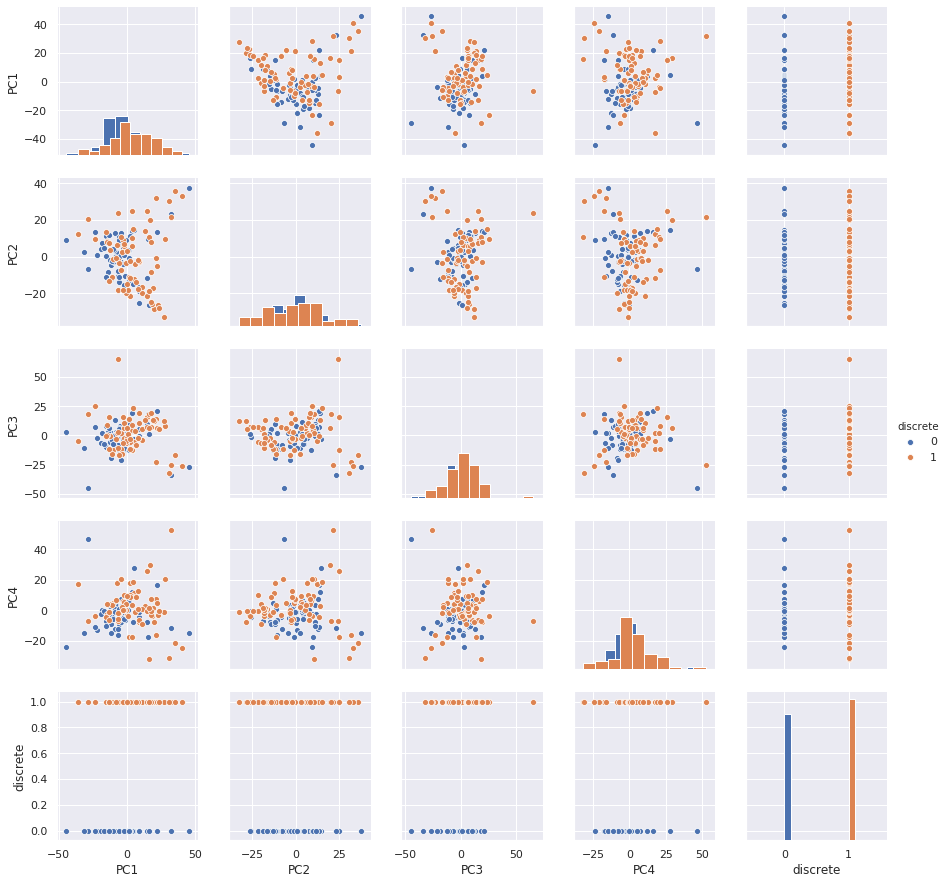

In [142]:
sns.pairplot(visualize, hue='discrete', diag_kind='hist')
plt.show()

In [155]:
pca.explained_variance_ratio_

array([0.03196416, 0.02840956, 0.02371688, 0.0203535 , 0.01969999,
       0.01834578, 0.01793886, 0.01720926, 0.01656328, 0.01562523])

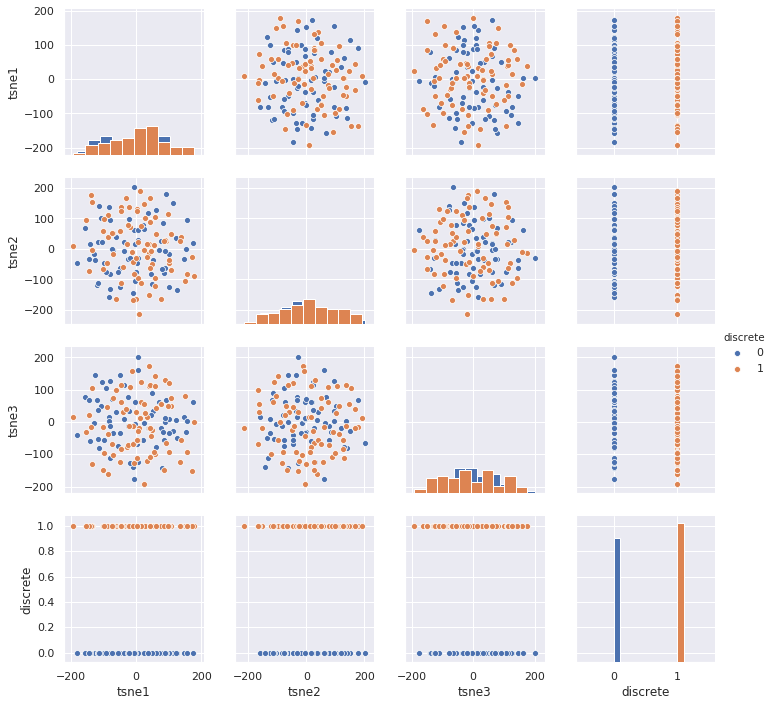

In [153]:
sns.pairplot(tsne_expression_df.loc[:,['tsne{}'.format(i) for i in range(1, 4)]+['discrete']] , hue='discrete', diag_kind='hist')
plt.show()